# Study of the resulting distributions
In this notebook we want to compare the resulting distributions by applying the wasserstein distance to quantify differences and similarities.
## Frequencies of Linguistic Elements
To assess the similarity of the resulting distributions, we compute the [*Wasserstein-Metric*](https://en.wikipedia.org/wiki/Wasserstein_metric) of each pair of distributions.
The Wasserstein-Metric is a distance function for probability distributions. It satisfies the criteria of actual metrics and thus enables comparisons between probability distributions. Assuming one-dimensional distributions, the Wasserstein Distance of two empirical samples $P$ and $Q$ with respective random vectors $X_1,...,X_n$ and $Y_1,...,Y_n$ is given by:
$$ W_{p}(P,Q)=\left({\frac {1}{n}}\sum _{i=1}^{n}\|X_{(i)}-Y_{(i)}\|^{p}\right)^{\frac {1}{p}}$$ 
Let's compute the Wasserstein-Metric for the distributions of query intent, PII Entity Labels and Questions


### 1. Query Intent

In [1]:
from thesis_schneg.vis_modules import _get_results_paths, load_results

analyses = []

analyses.append('query-intent')
analyses.append('group-presidio-pii')
analyses.append('questions')

# test_data = True
test_data = False



Load Data:

In [2]:
from time import time
# load data

analysis_data = {}
for analysis in analyses:
    # col_name = 'query-intent'
    # title = 'Query Intent'
    if analysis == 'group-presidio-pii':
        cleaned_aql = True
        # col_name = 'entity-label'
        # title = 'PII Entity Labels'
    else:
        cleaned_aql = False

    if analysis == 'questions':
        english = True
        # col_name = 'is-question'
        # title = 'Questions'
    else:
        english = False
    print(f"Start loading \"{analysis}\"")
    datasets = {}
    for dataset in ["aol","aql","ms-marco","orcas"]:
        start_time = time()
        paths = _get_results_paths(dataset, analysis, cleaned_aql=cleaned_aql, english=english)
        result_data = load_results(paths, test_data=test_data)
        datasets.update({dataset: result_data})
        end_time = time()
        print(f"{dataset.upper()} loaded in {(end_time - start_time)/60} min")
    analysis_data.update({analysis: datasets})

Start loading "query-intent"
AOL loaded in 0.017576960722605388 min
AQL loaded in 0.018722903728485108 min
MS-MARCO loaded in 0.020243374506632487 min
ORCAS loaded in 0.019006792704264322 min
Start loading "group-presidio-pii"
AOL loaded in 0.05442590713500976 min
aql-group-presidio-pii-special
AQL loaded in 0.02663526137669881 min
MS-MARCO loaded in 0.022110899289449055 min
ORCAS loaded in 0.02284619410832723 min
Start loading "questions"
AOL loaded in 0.010991454124450684 min
AQL loaded in 0.012301238377888997 min
MS-MARCO loaded in 0.012404962380727132 min
ORCAS loaded in 0.012871301174163819 min


Compute Wasserstein-Distances:

In [3]:
from pandas import DataFrame
import numpy as np
cnt=0
distances_data = {}

for analysis, datasets in analysis_data.items():

    col_name = 'query-intent'
    if analysis == 'group-presidio-pii':
        col_name = 'entity-label'
        # title = 'PII Entity Labels'
    if analysis == 'questions':
        col_name = 'is-question'
        # title = 'Questions'

    distances = DataFrame(np.zeros((len(datasets), len(datasets))), index=datasets.keys(), columns=datasets.keys())
    names = []
    j=0
    for dataset_name, data in datasets.items():
        names.append(dataset_name)
        data = data.sort_values(by=[col_name], ascending=False)
        # remove the columns that contain less than 0.4% of the total count
        data = data[data['count()'] > 0.004 * data['count()'].sum()]
        y_vals = (data['count()']/data['count()'].sum()).to_numpy()
        print(f"{dataset_name}: {y_vals}")
        i=0
        for dataset_name, data in datasets.items():
            if dataset_name in names:
                dist = 0
            else:
                data = data.sort_values(by=[col_name], ascending=False)
                data = data[data['count()'] > 0.004 * data['count()'].sum()]

                y_vals2 = (data['count()']/data['count()'].sum()).to_numpy()
                # in this cas,e the wasserstein distance corresponds to the differences of the counts in the categories multiplied by 1/2
                # we postulate a distance of 1 between the categories: dist(informational, navigational) = 1
                dist = 0.5 * np.sum(np.abs(y_vals - y_vals2)) 

            distances.iloc[i, j] = dist
            i+=1
        j+=1
    distances = distances + distances.T
    distances_data.update({analysis: distances})
    cnt+=1
for key, value in distances_data.items():
    print(value)

## get avarage wasserstein distances per query log
avg_distances = {}
for analysis, distances in distances_data.items():
    avg_distances.update({analysis: distances.mean().mean()})
    
for key, value in avg_distances.items():
    print(key, value)

aol: [0.02291327 0.32459064 0.65249608]
aql: [0.01649598 0.16222364 0.82128038]
ms-marco: [0.02944043 0.06608317 0.90447639]
orcas: [0.0422712  0.12696737 0.83076143]
aol: [0.47971753 0.07625585 0.3768081  0.06721852]
aql: [0.51219917 0.05837077 0.17134207 0.25808799]
ms-marco: [0.62500995 0.05187251 0.23352949 0.08958805]
orcas: [0.39204745 0.07637093 0.37781128 0.15377034]
aol: [0.00969827 0.99030173]
aql: [0.0150902 0.9849098]
ms-marco: [0.03877327 0.96122673]
orcas: [0.08438297 0.91561703]
               aol       aql  ms-marco     orcas
aol       0.000000  0.168784  0.258507  0.197623
aql       0.168784  0.000000  0.096140  0.035256
ms-marco  0.258507  0.096140  0.000000  0.073715
orcas     0.197623  0.035256  0.073715  0.000000
               aol       aql  ms-marco     orcas
aol       0.000000  0.223351  0.167662  0.087670
aql       0.223351  0.000000  0.174998  0.224469
ms-marco  0.167662  0.174998  0.000000  0.232962
orcas     0.087670  0.224469  0.232962  0.000000
           

By applying MDS, we project the configuration into 2D and create another plot:

In [4]:
# from sklearn.manifold import MDS
# mds = MDS(n_components=2, dissimilarity='precomputed')

# distances = distances_data[analysis]

# print(distances)
# points =  mds.fit_transform(distances)
# print(points)

from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed')
trans_dists = {}
for key, value in distances_data.items():
    print(key)
    trans_dists.update({key: mds.fit_transform(value)})
    

query-intent
group-presidio-pii
questions


['Query Intent', 'PII Entities', 'Questions']


/tmp/ipykernel_7859/3098206233.py:114: UserWarning: linewidths is ignored by contourf
  ax.contourf(X.astype(float), Y.astype(float), Z.astype(float), 10, alpha=0.7, cmap = 'Blues', linewidths=0.5, linestyles='solid') #, cmap='Blues' 'OrRd'


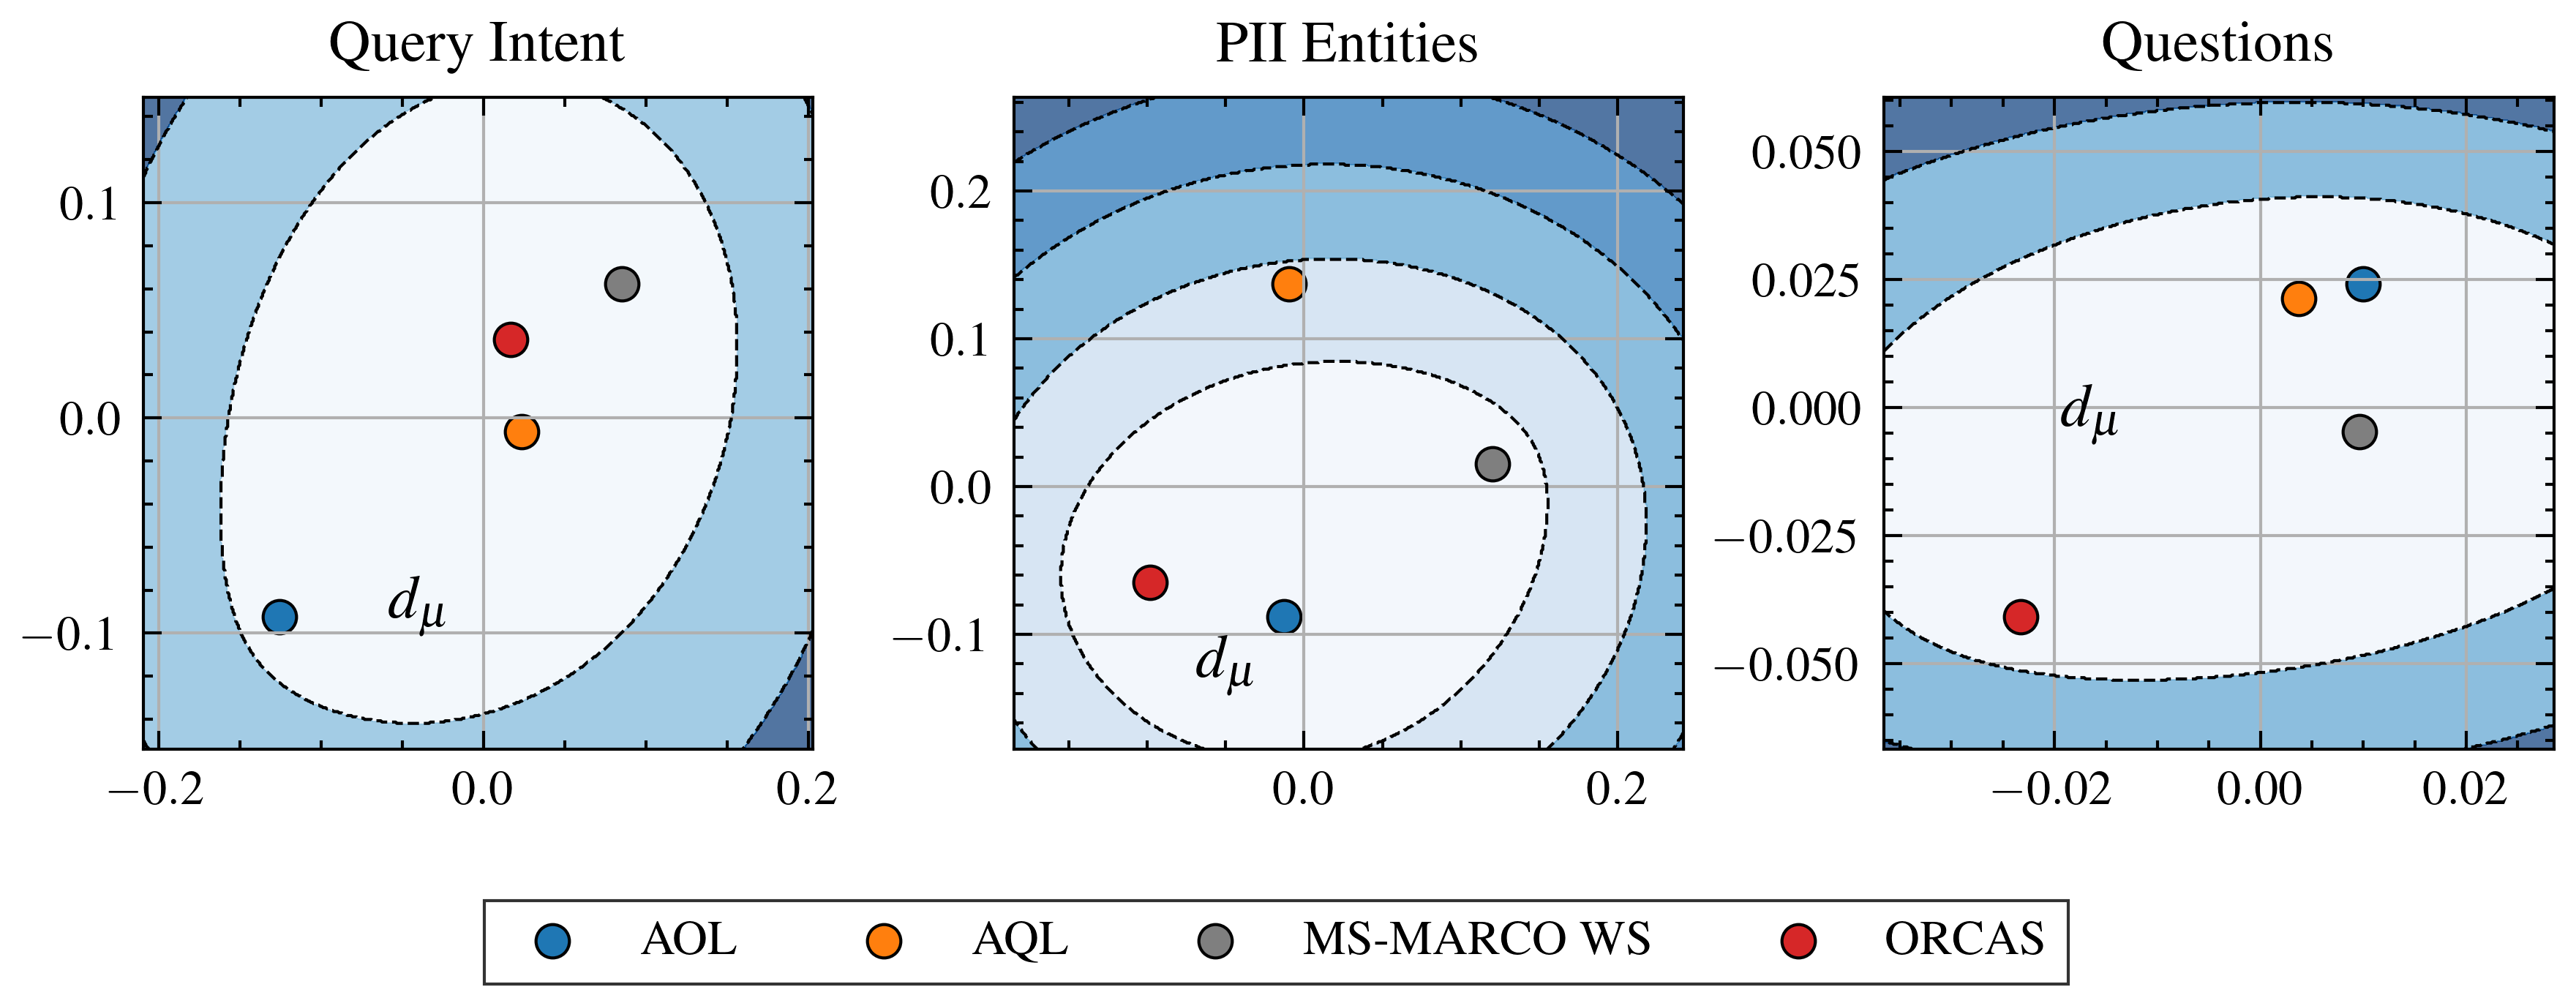

In [10]:
from matplotlib import pyplot as plt
from pathlib import Path  
from sklearn.manifold import MDS
import scienceplots

 # now we create a colormap, that reflects the average distance of a point to the 3 points of AOL, ORCAS, MS-MARCO Web Search
# index 1 in the points array is the point of AQL
def avg_dist_notAQL(x,y, point_matrtix):
    dist = 0
    for i in range(len(point_matrtix)):
        if i != 1:
            dist += np.sqrt((x - point_matrtix[i][0])**2 + (y - point_matrtix[i][1])**2)
    dist = dist/3
    # return dist
    # # get the average distance of the points within AOL, ORCAS, MS-MARCO Web Search    
    avg_dist_within = 0
    for i in [(0,2), (0,3), (2,3)]:
        avg_dist_within += np.sqrt((point_matrtix[i[0]][0] - point_matrtix[i[1]][0])**2 + (point_matrtix[i[0]][1] - point_matrtix[i[1]][1])**2)
    avg_dist_within = avg_dist_within/3

    # get the standard deviation of distances within AOL, ORCAS, MS-MARCO Web Search
    std_dist_within = 0
    for i in [(0,2), (0,3), (2,3)]:
        std_dist_within += (np.sqrt((point_matrtix[i[0]][0] - point_matrtix[i[1]][0])**2 + (point_matrtix[i[0]][1] - point_matrtix[i[1]][1])**2) - avg_dist_within)**2
    std_dist_within = np.sqrt(std_dist_within/3) 

    if dist <= avg_dist_within:
        return avg_dist_within
    elif dist > avg_dist_within and dist <= avg_dist_within + std_dist_within:
        return avg_dist_within + std_dist_within
    elif dist > avg_dist_within + std_dist_within and dist <= avg_dist_within + 2 * std_dist_within:
        return avg_dist_within + 2 * std_dist_within
    elif dist > avg_dist_within + 2 * std_dist_within and dist <= avg_dist_within + 3 * std_dist_within:
        return avg_dist_within + 3 * std_dist_within
    elif dist > avg_dist_within + 3 * std_dist_within and dist <= avg_dist_within + 4 * std_dist_within:
        return avg_dist_within + 4 * std_dist_within
        
def avg_dist_within(points):
    dist = 0
    pairs = [(0, 2), (0, 3), (2, 3)]  # Indizes der Punkte AOL, MS-MARCO, ORCAS
    for i, j in pairs:
        dist += np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)
    return dist / len(pairs)
def std_within(points):
    dist = 0
    pairs = [(0, 2), (0, 3), (2, 3)]  # Indizes der Punkte AOL, MS-MARCO, ORCAS
    for i, j in pairs:
        dist += (np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2) - avg_dist_within(points))**2
    return np.sqrt(dist / len(pairs))

# use science style for plots from scienceplots library
plt.style.use(["science", "ieee"])

color =  ['tab:blue', 'tab:orange', 'tab:gray', 'tab:red']

save_vis = True
# save_vis = False

# get meshsize
# mesh_size = 70
mesh_size = 500

num_plots = 3
cols = 3
rows = num_plots//cols
if num_plots % cols != 0:
    rows+=1

textwidth = 5.5129
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale *1.1
height = width * aspect_ratio * 0.45


fig,ax = plt.subplots(rows,cols, figsize=(width,height))

titles = ["Query Intent", "PII Entities", "Questions"]
print(titles)

positions = [[0.0,0.0], [0.0,-0.6], [-0.02,0.0]]
keys = [key for key in trans_dists.keys()]

axes = ax.flatten()
for i in range(len(trans_dists)):
    ax = axes[i]
    ax.set_title(titles[i])

    points = trans_dists[keys[i]]
    # get the highes and lowest x and y values of the points
    x_min = np.min(points[:,0])
    x_max = np.max(points[:,0])
    y_min = np.min(points[:,1])
    y_max = np.max(points[:,1])

    # scale the extreme values of x and y to get a good boundary for the plot
    # we take the scale of the min range
    range_scale = 0.4
    x_min = x_min - range_scale * (x_max - x_min)
    x_max = x_max + range_scale * (x_max - x_min)
    y_min = y_min - range_scale * (y_max - y_min)
    y_max = y_max + range_scale * (y_max - y_min)

    x = np.linspace(x_min, x_max, mesh_size)
    y = np.linspace(y_min, y_max, mesh_size)
    z = np.array([avg_dist_notAQL(i,j,points) for j in y for i in x])

    X, Y = np.meshgrid(x, y)
    Z = z.reshape(mesh_size, mesh_size)

    avg_dist = avg_dist_within(points)
    std_dist = std_within(points)

    ax.contourf(X.astype(float), Y.astype(float), Z.astype(float), 10, alpha=0.7, cmap = 'Blues', linewidths=0.5, linestyles='solid') #, cmap='Blues' 'OrRd'
    # Add contour lines for the average distance within AOL, MS-MARCO, and ORCAS and the standard deviation 
    contour = ax.contour(X, Y, Z, levels=[avg_dist, avg_dist+std_dist, avg_dist+2*std_dist, avg_dist+3*std_dist], colors='black', linewidths=0.5, linestyles='dashed')

    # Label the contour lines with descriptive text
    # text = ["$d_{{\mu}}$", "$d_{{\mu}} + \sigma$", "$d_{{\mu}} + 2 \sigma$"]
    text = ["$d_{{\mu}}$","",""]

    for i, level in enumerate(contour.levels):
        # Find the position for the label (e.g., the midpoint of the contour line)
        idx = np.where(Z == level)
        if len(idx[0]) > 0:
            if i > 0 and i < 2:
                # Find the position where y is closest to 0
                y_closest_to_zero_idx = np.argmin(np.abs(Y[idx]))
                x_pos = X[idx][y_closest_to_zero_idx] +0.006
                y_pos = Y[idx][y_closest_to_zero_idx] -0.015
                ax.text(x_pos, y_pos, text[i] , fontsize=10, color='black')
            elif i == 0:
                x_pos = X[idx[0][0], idx[1][0]] - 0.005# Shift slightly in the x-direction
                y_pos = Y[idx[0][0], idx[1][0]] + 0.05
                ax.text(x_pos, y_pos, text[i] , fontsize=10, color='black')

    labels = [name.upper() for name in names]
    labels[2] = "MS-MARCO WS"
    # plot 3d scatter plot
    for j in range(len(points)):
        ax.scatter(points[j][0], points[j][1], c=color[j], label=labels[j], s=30, edgecolor='black', linewidth=0.5)



    ax.grid(True)
handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=False, ncol=len(names),edgecolor="black", frameon=True).get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.show()

base_path = "/home/benjamin/studium/masterarbeit/thesis-schneg/plots/"

vis_dir = Path(f"{base_path}Wasserstein-Distances-inference-2d-contour")
if not vis_dir.exists() and save_vis:
        vis_dir.mkdir(parents=True)

if not vis_dir.exists() and save_vis:
        vis_dir.mkdir(parents=True)

if save_vis:
    fig.savefig(vis_dir.joinpath("all.pdf"), format='pdf')